In [3]:
#!/usr/bin/env python
# coding: utf-8

"""
Multi Objective Optimization of Integrated Bridge and Road Maintenance
with Parallel Coordinates and AHP based Decision Support

This project demonstrates a complete workflow:
    - 6 decision variables (intervention intervals for bridge and road)
    - 3 conflicting objectives: minimize downtime, maximize minimum gap, minimize cost
    - NSGA II to generate the Pareto front
    - AHP to incorporate stakeholder preferences and select a preferred solution
    - Parallel coordinates to visualize the entire Pareto set

All visualizations are saved as PNG files.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# =============================================================================
# 1. Problem Data
# =============================================================================

LIFETIME = 70

# Bridge intervention parameters
bridge = {
    'SDO': {'range': (10, 20), 'duration': 7,   'cost': 5000,   'ideal': 15},
    'M':   {'range': (3, 8),   'duration': 2,   'cost': 2000,   'ideal': 5},
    'DR':  {'range': (20, 35), 'duration': 21,  'cost': 50000,  'ideal': 30}
}

# Road intervention parameters
road = {
    'SDO.r': {'range': (12, 25), 'duration': 7,  'cost': 6000,   'ideal': 18},
    'M.r':   {'range': (5, 10),  'duration': 2,  'cost': 2500,   'ideal': 7},
    'R.r':   {'range': (27, 37), 'duration': 21, 'cost': 60000,  'ideal': 32}
}

# Penalty for deviating from ideal intervals
PENALTY_SCALE = 1e4


In [5]:
# =============================================================================
# 2. Helper Functions
# =============================================================================

def generate_events(intervals_dict):
    """Return list of (year, event_name)."""
    events = []
    for name, interval in intervals_dict.items():
        if interval <= 0 or interval >= LIFETIME:
            continue
        years = np.arange(interval, LIFETIME, interval)
        for y in years:
            events.append((y, name))
    events.sort(key=lambda x: x[0])
    return events

def compute_downtime_and_gap(events_bridge, events_road):
    """Return total downtime (days) and minimum gap between successive events (years)."""
    all_events = events_bridge + events_road
    if not all_events:
        return 0, LIFETIME
    all_events.sort(key=lambda x: x[0])

    import itertools
    total_downtime = 0
    years_list = []
    for year, group in itertools.groupby(all_events, key=lambda x: x[0]):
        years_list.append(year)
        events_this_year = [ev for _, ev in group]
        max_dur = 0
        for ev in events_this_year:
            if ev in bridge:
                max_dur = max(max_dur, bridge[ev]['duration'])
            else:
                max_dur = max(max_dur, road[ev]['duration'])
        total_downtime += max_dur

    if len(years_list) >= 2:
        gaps = np.diff(years_list)
        min_gap = np.min(gaps)
    else:
        min_gap = LIFETIME
    return total_downtime, min_gap

def compute_cost(events_bridge, events_road, intervals_bridge, intervals_road):
    """Total cost = sum of per‑event costs + quadratic penalty for deviation from ideal."""
    cost = 0
    for _, ev in events_bridge:
        cost += bridge[ev]['cost']
    for _, ev in events_road:
        cost += road[ev]['cost']

    for name, ideal in [(n, bridge[n]['ideal']) for n in bridge] + [(n, road[n]['ideal']) for n in road]:
        if name in intervals_bridge:
            dev = intervals_bridge[name] - ideal
        else:
            dev = intervals_road[name] - ideal
        cost += PENALTY_SCALE * dev**2
    return cost

In [6]:
# =============================================================================
# 3. Multi‑Objective Problem Definition
# =============================================================================

class IntegratedMaintenanceProblem(Problem):
    """
    Decision variables: [SDO, M, DR, SDO.r, M.r, R.r] intervals (years)
    Objectives (minimize):
        f0: total downtime (days)
        f1: - (minimum gap)   → so maximizing gap is achieved by minimizing f1
        f2: total cost (€)
    """
    def __init__(self):
        xl = np.array([bridge['SDO']['range'][0],
                       bridge['M']['range'][0],
                       bridge['DR']['range'][0],
                       road['SDO.r']['range'][0],
                       road['M.r']['range'][0],
                       road['R.r']['range'][0]])
        xu = np.array([bridge['SDO']['range'][1],
                       bridge['M']['range'][1],
                       bridge['DR']['range'][1],
                       road['SDO.r']['range'][1],
                       road['M.r']['range'][1],
                       road['R.r']['range'][1]])
        super().__init__(n_var=6, n_obj=3, xl=xl, xu=xu)

    def _evaluate(self, X, out, *args, **kwargs):
        n = X.shape[0]
        F = np.zeros((n, 3))

        for i in range(n):
            intervals_bridge = {
                'SDO': X[i,0],
                'M':   X[i,1],
                'DR':  X[i,2]
            }
            intervals_road = {
                'SDO.r': X[i,3],
                'M.r':   X[i,4],
                'R.r':   X[i,5]
            }

            events_bridge = generate_events(intervals_bridge)
            events_road   = generate_events(intervals_road)

            downtime, min_gap = compute_downtime_and_gap(events_bridge, events_road)
            cost = compute_cost(events_bridge, events_road, intervals_bridge, intervals_road)

            F[i, 0] = downtime
            F[i, 1] = -min_gap      # minimize negative gap
            F[i, 2] = cost

        out["F"] = F

In [7]:
# =============================================================================
# 4. Run NSGA‑II
# =============================================================================

problem = IntegratedMaintenanceProblem()

algorithm = NSGA2(
    pop_size=100,
    eliminate_duplicates=True
)

res = minimize(
    problem,
    algorithm,
    ('n_gen', 100),
    seed=42,
    verbose=True
)

print("Optimization completed.")
print(f"Number of non‑dominated solutions: {len(res.F)}")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     14 |             - |             -
     2 |      200 |     20 |  0.0614291015 |             f
     3 |      300 |     24 |  0.0600000000 |         ideal
     4 |      400 |     37 |  0.2710962770 |         ideal
     5 |      500 |     45 |  0.0030641883 |         ideal
     6 |      600 |     44 |  0.2115384615 |         nadir
     7 |      700 |     48 |  0.1475409836 |         nadir
     8 |      800 |     48 |  0.0714285714 |         ideal
     9 |      900 |     51 |  0.0099464138 |         ideal
    10 |     1000 |     61 |  0.0260696628 |             f
    11 |     1100 |     64 |  0.0117795535 |         ideal
    12 |     1200 |     60 |  0.0740740741 |         nadir
    13 |     1300 |     47 |  0.0072338233 |         ideal
    14 |     1400 |     48 |  0.0754253226 |         ideal
    15 |     1500 |     57 |  0.0406508687 |         ideal
    16 |     1600 |     55 |  0.0361953176 |         nad

In [8]:
# =============================================================================
# 5. Prepare DataFrames for Analysis
# =============================================================================

pareto_X = pd.DataFrame(res.X, columns=['SDO', 'M', 'DR', 'SDO.r', 'M.r', 'R.r'])
pareto_F = pd.DataFrame(res.F, columns=['Downtime', 'NegMinGap', 'Cost'])
pareto_F['MinGap'] = -pareto_F['NegMinGap']          # positive minimum gap
pareto_F['Cost_M'] = pareto_F['Cost'] / 1e6          # cost in millions €

print("\nObjective ranges on Pareto front:")
print(pareto_F[['Downtime', 'MinGap', 'Cost_M']].describe())


Objective ranges on Pareto front:
         Downtime      MinGap      Cost_M
count  100.000000  100.000000  100.000000
mean   145.310000    0.393605    0.531628
std     15.918159    0.229706    0.176836
min    128.000000    0.009102    0.306285
25%    134.000000    0.216681    0.377705
50%    139.000000    0.365840    0.483177
75%    152.000000    0.614603    0.705484
max    184.000000    0.835699    0.864829


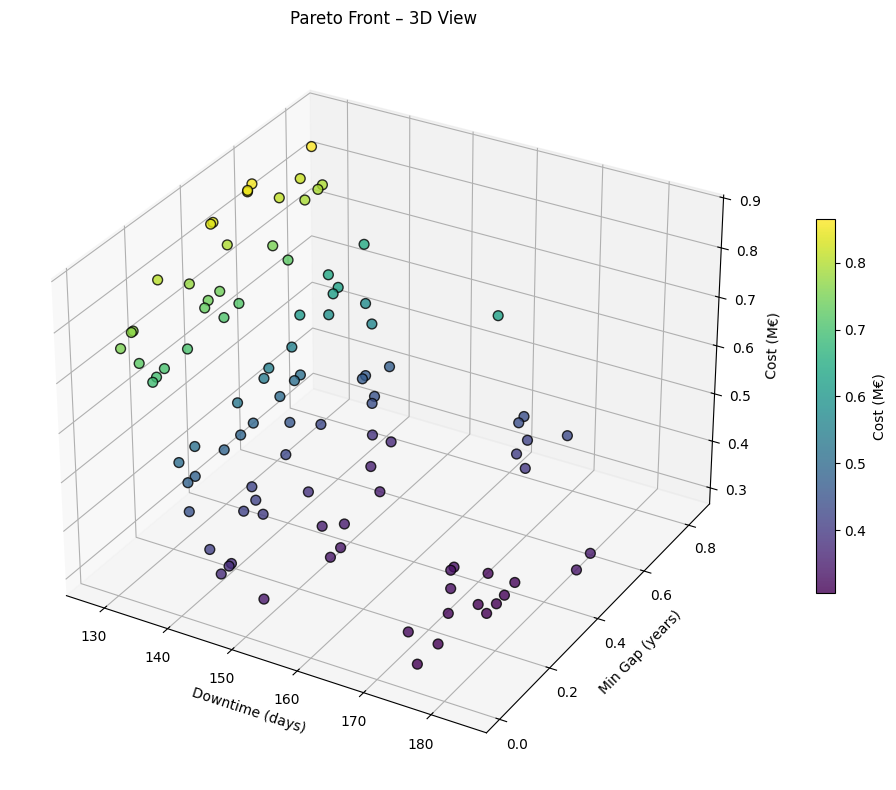

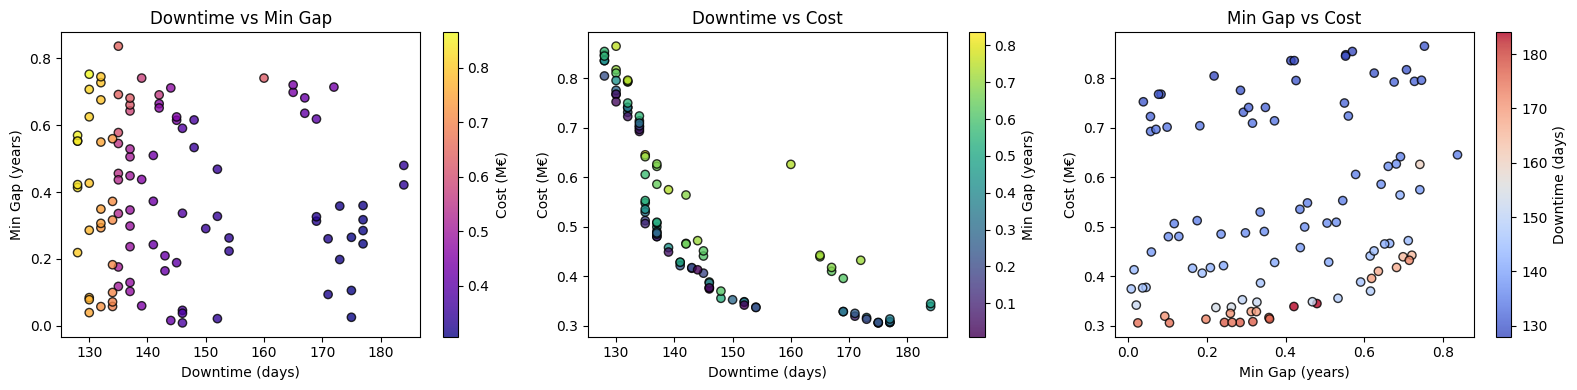

In [9]:
# =============================================================================
# 6. 2D and 3D Scatter Plots
# =============================================================================

# 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pareto_F['Downtime'], pareto_F['MinGap'], pareto_F['Cost_M'],
                c=pareto_F['Cost_M'], cmap='viridis', alpha=0.8, edgecolors='k', s=50)
ax.set_xlabel('Downtime (days)')
ax.set_ylabel('Min Gap (years)')
ax.set_zlabel('Cost (M€)')
ax.set_title('Pareto Front – 3D View')
plt.colorbar(sc, label='Cost (M€)', shrink=0.5)
plt.tight_layout()
plt.savefig('pareto_3d.png', dpi=150)
plt.show()

# 2D pairwise scatter plots
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ax = axes[0]
sc = ax.scatter(pareto_F['Downtime'], pareto_F['MinGap'],
                c=pareto_F['Cost_M'], cmap='plasma', alpha=0.8, edgecolors='k')
ax.set_xlabel('Downtime (days)')
ax.set_ylabel('Min Gap (years)')
ax.set_title('Downtime vs Min Gap')
plt.colorbar(sc, ax=ax, label='Cost (M€)')

ax = axes[1]
sc = ax.scatter(pareto_F['Downtime'], pareto_F['Cost_M'],
                c=pareto_F['MinGap'], cmap='viridis', alpha=0.8, edgecolors='k')
ax.set_xlabel('Downtime (days)')
ax.set_ylabel('Cost (M€)')
ax.set_title('Downtime vs Cost')
plt.colorbar(sc, ax=ax, label='Min Gap (years)')

ax = axes[2]
sc = ax.scatter(pareto_F['MinGap'], pareto_F['Cost_M'],
                c=pareto_F['Downtime'], cmap='coolwarm', alpha=0.8, edgecolors='k')
ax.set_xlabel('Min Gap (years)')
ax.set_ylabel('Cost (M€)')
ax.set_title('Min Gap vs Cost')
plt.colorbar(sc, ax=ax, label='Downtime (days)')

plt.tight_layout()
plt.savefig('pareto_2d_pairwise.png', dpi=150)
plt.show()





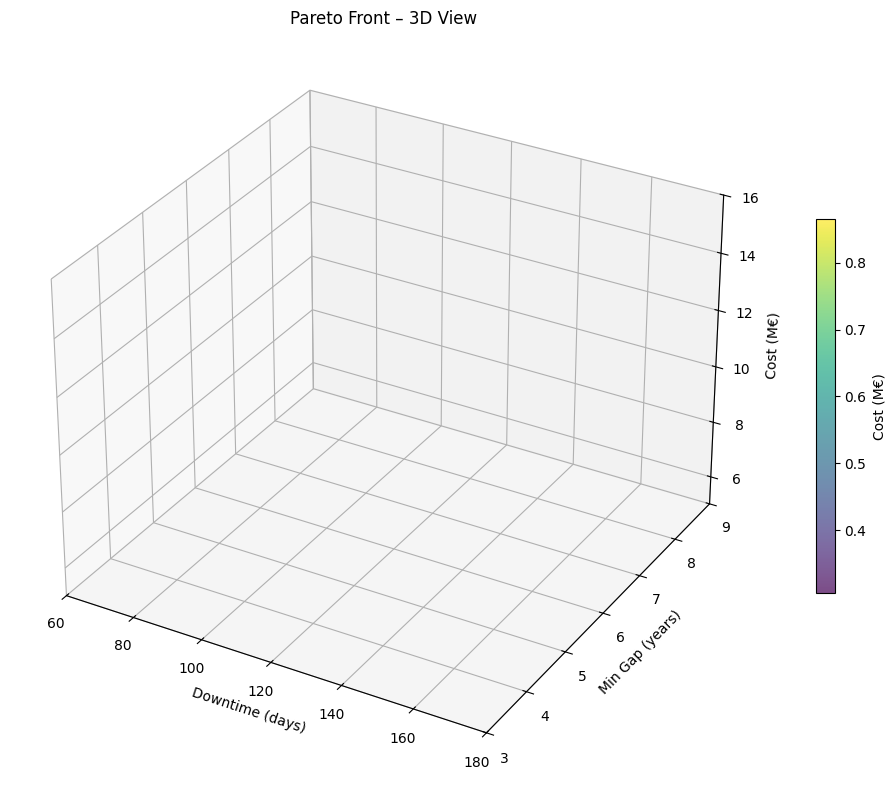

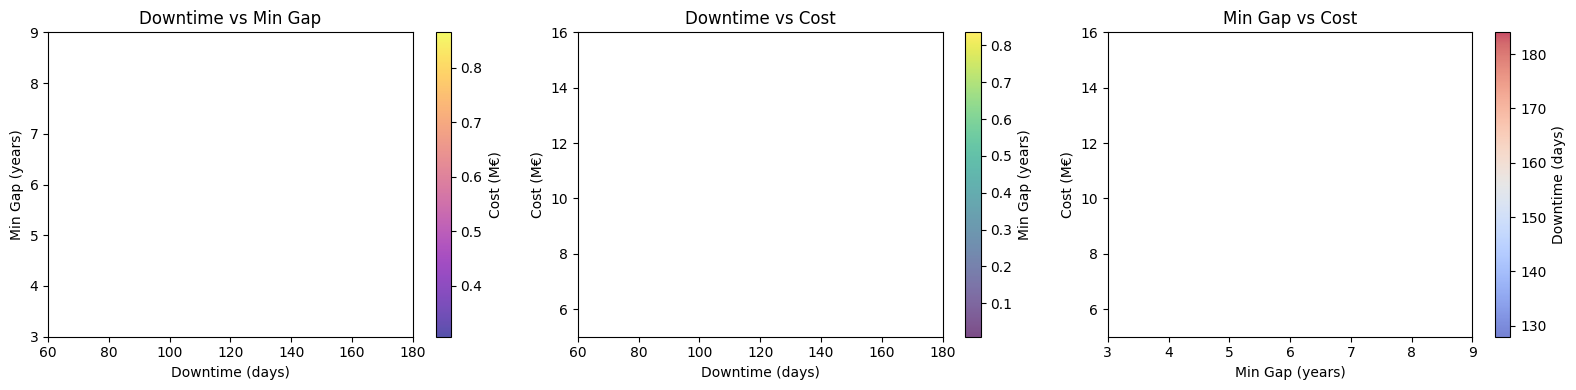

In [10]:
# =============================================================================
# 6. 2D and 3D Scatter Plots – with adjustable axis limits
# =============================================================================

# ---- Adjust these parameters to change the plot appearance ----
# Axis limits (set to None to use auto-scale, or provide (min, max) tuples)
XLIM_3D = (60, 180)          # Downtime (days) for 3D plot
YLIM_3D = (3, 9)             # Min Gap (years) for 3D plot
ZLIM_3D = (5, 16)            # Cost (M€) for 3D plot

# For 2D subplots (each tuple = (xmin, xmax, ymin, ymax) or None)
LIMITS_2D = [
    (60, 180, 3, 9),          # Downtime vs Min Gap
    (60, 180, 5, 16),         # Downtime vs Cost
    (3, 9, 5, 16)             # Min Gap vs Cost
]

# Point styling
ALPHA = 0.7
MARKER_SIZE = 40
EDGE_COLOR = 'k'
# --------------------------------------------------------------

# 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pareto_F['Downtime'], pareto_F['MinGap'], pareto_F['Cost_M'],
                c=pareto_F['Cost_M'], cmap='viridis', alpha=ALPHA, edgecolors=EDGE_COLOR, s=MARKER_SIZE)
ax.set_xlabel('Downtime (days)')
ax.set_ylabel('Min Gap (years)')
ax.set_zlabel('Cost (M€)')
ax.set_title('Pareto Front – 3D View')
if XLIM_3D is not None:
    ax.set_xlim(XLIM_3D)
if YLIM_3D is not None:
    ax.set_ylim(YLIM_3D)
if ZLIM_3D is not None:
    ax.set_zlim(ZLIM_3D)
plt.colorbar(sc, label='Cost (M€)', shrink=0.5)
plt.tight_layout()
plt.savefig('pareto_3d.png', dpi=150)
plt.show()

# 2D pairwise scatter plots
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Downtime vs Min Gap
ax = axes[0]
sc = ax.scatter(pareto_F['Downtime'], pareto_F['MinGap'],
                c=pareto_F['Cost_M'], cmap='plasma', alpha=ALPHA, edgecolors=EDGE_COLOR, s=MARKER_SIZE)
ax.set_xlabel('Downtime (days)')
ax.set_ylabel('Min Gap (years)')
ax.set_title('Downtime vs Min Gap')
if LIMITS_2D[0] is not None:
    ax.set_xlim(LIMITS_2D[0][0], LIMITS_2D[0][1])
    ax.set_ylim(LIMITS_2D[0][2], LIMITS_2D[0][3])
plt.colorbar(sc, ax=ax, label='Cost (M€)')

# Downtime vs Cost
ax = axes[1]
sc = ax.scatter(pareto_F['Downtime'], pareto_F['Cost_M'],
                c=pareto_F['MinGap'], cmap='viridis', alpha=ALPHA, edgecolors=EDGE_COLOR, s=MARKER_SIZE)
ax.set_xlabel('Downtime (days)')
ax.set_ylabel('Cost (M€)')
ax.set_title('Downtime vs Cost')
if LIMITS_2D[1] is not None:
    ax.set_xlim(LIMITS_2D[1][0], LIMITS_2D[1][1])
    ax.set_ylim(LIMITS_2D[1][2], LIMITS_2D[1][3])
plt.colorbar(sc, ax=ax, label='Min Gap (years)')

# Min Gap vs Cost
ax = axes[2]
sc = ax.scatter(pareto_F['MinGap'], pareto_F['Cost_M'],
                c=pareto_F['Downtime'], cmap='coolwarm', alpha=ALPHA, edgecolors=EDGE_COLOR, s=MARKER_SIZE)
ax.set_xlabel('Min Gap (years)')
ax.set_ylabel('Cost (M€)')
ax.set_title('Min Gap vs Cost')
if LIMITS_2D[2] is not None:
    ax.set_xlim(LIMITS_2D[2][0], LIMITS_2D[2][1])
    ax.set_ylim(LIMITS_2D[2][2], LIMITS_2D[2][3])
plt.colorbar(sc, ax=ax, label='Downtime (days)')

plt.tight_layout()
plt.savefig('pareto_2d_pairwise.png', dpi=150)
plt.show()


AHP weights for objectives (Downtime, MinGap, Cost): [0.16666667 0.33333333 0.5       ]
Consistency ratio: 0.0

Best solution according to AHP weights: Index 24
Decision variables:
SDO      14.790912
M         6.468589
DR       30.747997
SDO.r    17.860749
M.r       7.901782
R.r      35.106178
Name: 24, dtype: float64
Objective values:
  Downtime = 148.0 days
  Min Gap  = 0.6 years
  Cost     = 0.37 M€


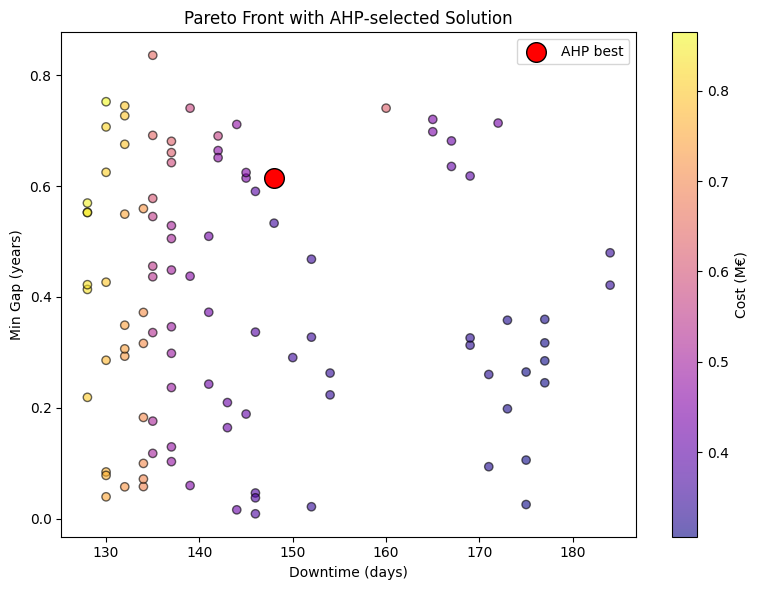

In [11]:
# =============================================================================
# 7. AHP to Select a Preferred Solution
# =============================================================================

def ahp_weights(pairwise_matrix):
    """Return normalized weights and consistency ratio."""
    n = pairwise_matrix.shape[0]
    eigvals, eigvecs = np.linalg.eig(pairwise_matrix)
    max_eig = np.max(eigvals.real)
    principal = eigvecs[:, np.argmax(eigvals.real)].real
    weights = principal / np.sum(principal)
    CI = (max_eig - n) / (n - 1)
    RI_dict = {1:0, 2:0, 3:0.58, 4:0.9, 5:1.12, 6:1.24, 7:1.32, 8:1.41, 9:1.45, 10:1.49}
    RI = RI_dict.get(n, 1.49)
    CR = CI / RI if RI != 0 else 0
    return weights, CR

# Pairwise comparison matrix for (Downtime, MinGap, Cost)
# Example: MinGap twice as important as Downtime, Cost three times as important as Downtime
obj_matrix = np.array([
    [1,   1/2, 1/3],
    [2,   1,   2/3],
    [3,   3/2, 1]
])
obj_weights, obj_CR = ahp_weights(obj_matrix)
print("\nAHP weights for objectives (Downtime, MinGap, Cost):", obj_weights)
print("Consistency ratio:", obj_CR)

# Normalize objective values (0 = best, 1 = worst)
F_min = res.F.min(axis=0)
F_max = res.F.max(axis=0)
F_norm = (res.F - F_min) / (F_max - F_min + 1e-10)   # 0 = best, 1 = worst
benefit = 1 - F_norm                                 # higher is better

overall_score = np.dot(benefit, obj_weights)
best_idx = np.argmax(overall_score)

print(f"\nBest solution according to AHP weights: Index {best_idx}")
print("Decision variables:")
print(pareto_X.iloc[best_idx])
print("Objective values:")
print(f"  Downtime = {pareto_F.loc[best_idx, 'Downtime']:.1f} days")
print(f"  Min Gap  = {pareto_F.loc[best_idx, 'MinGap']:.1f} years")
print(f"  Cost     = {pareto_F.loc[best_idx, 'Cost_M']:.2f} M€")

# Mark AHP best on a 2D plot
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(pareto_F['Downtime'], pareto_F['MinGap'],
                c=pareto_F['Cost_M'], cmap='plasma', alpha=0.6, edgecolors='k')
ax.scatter(pareto_F.loc[best_idx, 'Downtime'],
           pareto_F.loc[best_idx, 'MinGap'],
           color='red', s=200, edgecolor='black', label='AHP best')
ax.set_xlabel('Downtime (days)')
ax.set_ylabel('Min Gap (years)')
ax.set_title('Pareto Front with AHP‑selected Solution')
plt.colorbar(sc, ax=ax, label='Cost (M€)')
ax.legend()
plt.tight_layout()
plt.savefig('pareto_with_ahp.png', dpi=150)
plt.show()

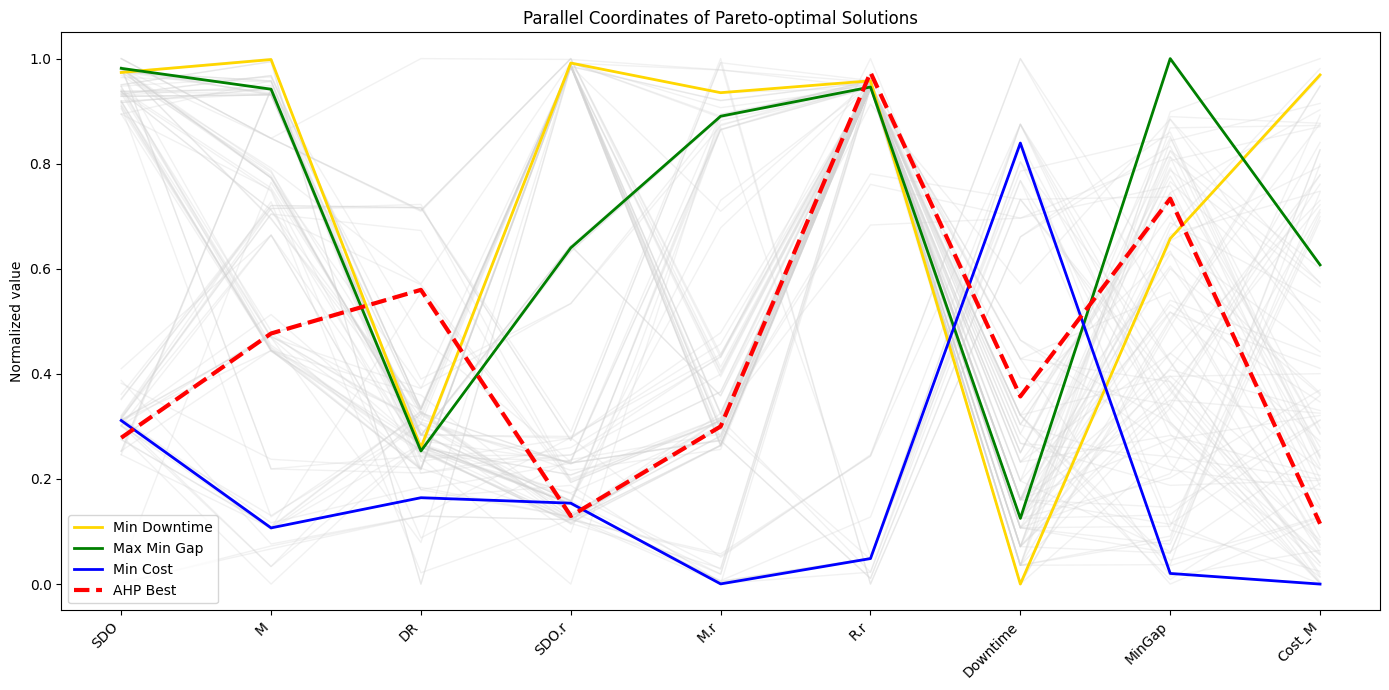

In [14]:
# =============================================================================
# 8. Parallel Coordinates (Decision Variables + Objectives)
# =============================================================================

# Combine decision variables and objectives (positive min gap, cost in M€)
all_data = pd.concat([
    pareto_X,
    pareto_F[['Downtime', 'MinGap', 'Cost_M']]
], axis=1)

# Normalize each column to [0,1]
norm = (all_data - all_data.min()) / (all_data.max() - all_data.min())

# Indices of extreme solutions
min_downtime_idx = pareto_F['Downtime'].idxmin()
max_gap_idx      = pareto_F['MinGap'].idxmax()
min_cost_idx     = pareto_F['Cost'].idxmin()   # original cost column
ahp_idx          = best_idx

plt.figure(figsize=(14, 7))

# Plot all Pareto solutions in light gray
for i in range(len(norm)):
    plt.plot(norm.columns, norm.iloc[i], color='lightgray', alpha=0.3, linewidth=1)

# Highlight extreme solutions
plt.plot(norm.columns, norm.iloc[min_downtime_idx], color='gold', linewidth=2, label='Min Downtime')
plt.plot(norm.columns, norm.iloc[max_gap_idx],      color='green', linewidth=2, label='Max Min Gap')
plt.plot(norm.columns, norm.iloc[min_cost_idx],     color='blue', linewidth=2, label='Min Cost')
plt.plot(norm.columns, norm.iloc[ahp_idx],          color='red', linewidth=3, linestyle='--', label='AHP Best')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Normalized value')
plt.title('Parallel Coordinates of Pareto‑optimal Solutions')
plt.legend()
plt.tight_layout()
plt.savefig('parallel_coordinates.png', dpi=150)
plt.show()


In [13]:
# =============================================================================
# 9. Summary
# =============================================================================
print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)
print("""
This project successfully demonstrates a multi‑objective optimization framework
for integrated maintenance planning of a bridge and its access road.

Key elements:
    - 6 decision variables (intervention intervals)
    - 3 conflicting objectives: minimize downtime, maximize minimum gap, minimize cost
    - NSGA‑II to generate a diverse Pareto front
    - AHP to incorporate stakeholder preferences and select a single solution
    - Parallel coordinates to visualize the trade‑offs across all variables

All figures are saved as PNG files. The code is modular and can be adapted to
other infrastructure systems by modifying the intervention dictionaries.
""")


PROJECT SUMMARY

This project successfully demonstrates a multi‑objective optimization framework
for integrated maintenance planning of a bridge and its access road.

Key elements:
    - 6 decision variables (intervention intervals)
    - 3 conflicting objectives: minimize downtime, maximize minimum gap, minimize cost
    - NSGA‑II to generate a diverse Pareto front
    - AHP to incorporate stakeholder preferences and select a single solution
    - Parallel coordinates to visualize the trade‑offs across all variables

All figures are saved as PNG files. The code is modular and can be adapted to
other infrastructure systems by modifying the intervention dictionaries.

